# TPE Hyperparameter Optimization of CNN - Hyperopt

In this notebook, we will use **TPE driven Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset and the open source Python package [Hyperopt](http://hyperopt.github.io/hyperopt/).

The MNIST dataset is availale in [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).


## Download dataset

- Navigate to the [MNIST website in Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
- Download the train.csv file
- Unzip and copy the train.csv file to where you see the SAVE_DATASETS-HERE.txt file
- Rename to mnist.csv

**Remember that you need to be logged in to be able to download the dataset**

## Notebook content

- Data Preparation
- Set up the hyperparameter search shape
- Set up a simple CNN
- Set up the objective function
- Perform Bayesian Optimization
- Evaluate Model Performance

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [4]:
from hyperopt import hp, tpe, fmin, Trials

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

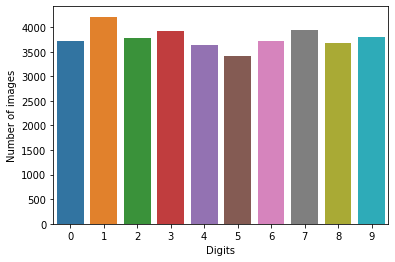

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

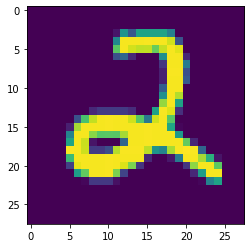

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

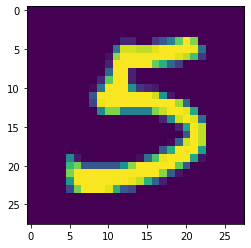

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define the Hyperparameter Space

Hyperopt provides the hp module to create distributions to sample the hyperparameters. More details in [Defining a Search Space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/).


We want to find the following hyper-parameters:

- The learning rate of the optimizer.
- The number of convolutional layers.
- The number of fully-connected Dense layers.
- The number of nodes (neurons) for each of the dense layers.
- Whether to use 'sigmoid' or 'relu' activation in all the layers.

In [14]:
# determine the hyperparameter space

param_grid = {
    'learning_rate': hp.uniform('learning_rate', 1e-6, 1e-2),
    'num_conv_layers': hp.quniform('num_conv_layers', 1, 3, 1),
    'num_dense_layers': hp.quniform('num_dense_layers', 1, 5, 1),
    'num_dense_nodes': hp.quniform('num_dense_nodes', 5, 512, 1),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
}

# Define the CNN

We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense layers. Each Convlutional layer, can itself have more than 1 conv layer.

In [15]:
# function to create the CNN

def create_cnn(
    # the hyperparam to optimize are passed
    # as arguments
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function and
    # the number of convolutional layers that it can take.
    
    # We add the different number of conv layers in the following loop:
    
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Same hyperparameters to optimize as previous layer.
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the Objective Function

In [16]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [17]:
def objective(params):
    
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Print the hyper-parameters.        
    print('learning rate: ', params['learning_rate'])
    print('num_conv_layers: ', int(params['num_conv_layers']))
    print('num_dense_layers: ',int(params['num_dense_layers']))
    print('num_dense_nodes: ', int(params['num_dense_nodes']))
    print('activation: ', params['activation'])
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=params['learning_rate'],
                       num_conv_layers=int(params['num_conv_layers']),
                       num_dense_layers=int(params['num_dense_layers']),
                       num_dense_nodes=int(params['num_dense_nodes']),
                       activation=params['activation'],
                       )

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

## Test run

In [18]:
# Before we run the hyper-parameter optimization,
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = {
    'learning_rate': 1e-5,
    'num_conv_layers': 1,
    'num_dense_layers': 1,
    'num_dense_nodes': 16,
    'activation': 'relu',
}


objective(default_parameters)

learning rate:  1e-05
num_conv_layers:  1
num_dense_layers:  1
num_dense_nodes:  16
activation:  relu

Epoch 1/3
266/266 [==============================] - 31s 112ms/step - loss: 2.2763 - accuracy: 0.1598 - val_loss: 2.1896 - val_accuracy: 0.4005
Epoch 2/3
266/266 [==============================] - 29s 108ms/step - loss: 2.1463 - accuracy: 0.4596 - val_loss: 1.9901 - val_accuracy: 0.5704
Epoch 3/3
266/266 [==============================] - 30s 111ms/step - loss: 1.9163 - accuracy: 0.6062 - val_loss: 1.6954 - val_accuracy: 0.6399

Accuracy: 63.99%



-0.6399471163749695

We obtained a mediocre accuracy, but all our code is working. So let's get started with the Optimization now!!

## Bayesian Optimization with TPE

In [ ]:
# fmin performs the minimization
# tpe.suggest samples the parameters following tpe

# with default parameters for TPE
trials = Trials()

search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=30,
    rstate=np.random.RandomState(42),
    algo=tpe.suggest,  # tpe
    trials=trials
)

In [20]:
# tpe.suggest default parameters:
# https://github.com/hyperopt/hyperopt/blob/master/hyperopt/tpe.py#L781
    
# to override the defo parameters:
# https://github.com/hyperopt/hyperopt/issues/632

In [21]:
# trials = Trials()

# # to override tpe.suggest default parameters
# tpe_modified = partial(tpe.suggest, verbose=False)

# search = fmin(
#     fn=objective,
#     space=param_grid,
#     max_evals=30,
#     rstate=np.random.RandomState(42),
#     algo=tpe_modified,  # tpe
#     trials=trials
# )

# Analyze results

In [22]:
# the best hyperparameters can also be found in
# trials

trials.argmin

{'activation': 0,
 'learning_rate': 0.0018850644923625356,
 'num_conv_layers': 1.0,
 'num_dense_layers': 5.0,
 'num_dense_nodes': 377.0}

In [23]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

,activation,learning_rate,num_conv_layers,num_dense_layers,num_dense_nodes,loss,status
0,1,0.008028,2.0,2.0,417.0,-0.093651,ok
1,1,0.009010,2.0,1.0,267.0,-0.093651,ok
2,1,0.003086,3.0,2.0,452.0,-0.096032,ok
3,1,0.008377,2.0,5.0,281.0,-0.114550,ok
4,0,0.007043,3.0,4.0,151.0,-0.114550,ok


Text(0.5, 0, 'Hyperparam combination')

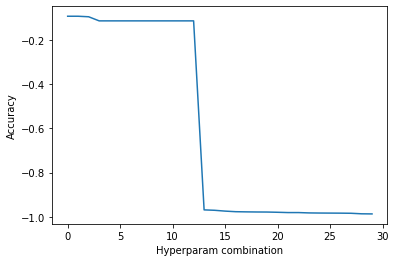

In [24]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

# Evaluate the model

In [25]:
# load best model

model = load_model(path_best_model)

In [26]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 1s 9ms/step - loss: 0.0514 - accuracy: 0.9862


In [27]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.05139937251806259
accuracy 0.9861904978752136


## Confusion matrix

In [28]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[412,   0,   0,   0,   0,   0,   4,   0,   4,   2],
       [  0, 469,   2,   0,   0,   0,   0,   1,   1,   0],
       [  1,   0, 404,   4,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1, 421,   0,   1,   0,   1,   1,   1],
       [  1,   3,   0,   0, 421,   0,   4,   0,   0,   0],
       [  0,   0,   0,   1,   0, 377,   2,   0,   2,   0],
       [  0,   0,   0,   0,   0,   1, 411,   0,   0,   0],
       [  0,   1,   4,   0,   0,   1,   0, 463,   0,   0],
       [  0,   1,   1,   0,   0,   1,   1,   0, 379,   1],
       [  1,   0,   0,   1,   6,   0,   0,   1,   0, 385]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

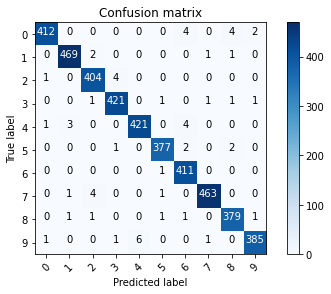

In [29]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.